In [258]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [13]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup 
import requests

targetUrl = "https://www.imdb.com/search/title/?release_date=2021-01-01,2021-12-31"

def getHTMLfromURL(url):
    return requests.get(url)

def parseSelectedHTML(rawHTML, parserType):
    parsedHTML = BeautifulSoup(rawHTML.content, parserType)
    listerList = parsedHTML.find('div', class_ = "lister-list")
    
    listerList.prettify()
    listerListContent = listerList.find_all('div', class_ = "lister-item-content")

    return listerListContent

def mappingHTML(html):
    contents = []
    for i in html:
        #to convert result into string object
        titles = i.find('a').string 
        
        # Extract Genre
        genre = i.find('span', {'class' : "genre"})
        General_genres = ''
        Specific_genres = ''
        if genre != None:
            genre = genre.string.split(',') #split string into list
            General_genres = genre[-1].strip()  #slice genre last list to describe the movie in general genre
            Specific_genres = genre[0].strip()  #slice genre first list to describe the movie in specific genre
        
            
        # Extracting Movie's PG Rating
        pg_rate = i.find('span',  class_ = "certificate")
        if pg_rate != None:
            pg_rate = pg_rate.string
        
            
        # Extracting Movie's IMDB Rating
        ratings = i.find('strong') #to convert from string into float
        if ratings != None:
            ratings = float(ratings.string.strip())
             
            
        # Extracting Movie's Votes
        votes = i.find('span', {'name':'nv'})
        if votes != None:
            votes = votes.string.replace(',', '') #to remove (,) in the number of votes
            
            
        # Extracting Movie's Metascore
        metascore = i.find('span', {'class':'metascore favorable'})
        if metascore != None:                           #To return each output with conditional statemenent with desired format
            metascore = metascore.string.strip() 
            
        content = (titles, General_genres, Specific_genres, pg_rate, ratings, votes, metascore)
        contents.append(content)
    
    return contents


def executeWebScrapping (nextPage, numberPage):
    limit = 0
    dataSource = []

    for i in range(nextPage, numberPage):
        limit = (i * 50) + 1
        url = targetUrl + "&start=" + str(limit) + "&ref_=adv_nxt"

        rawHTML = getHTMLfromURL(url)
        parsedHTML = parseSelectedHTML(rawHTML, 'html.parser')
        contents = mappingHTML(parsedHTML)

        dataSource = [*dataSource, *contents]

    return dataSource

In [14]:
data = executeWebScrapping(0, 201)

In [69]:
movieDF = pd.DataFrame(data, columns = ['Title', 'General_genres', 'Specific_genres', 'pg_rate', 'Imdb_Ratings',
                        'Votes', 'Metascore'], index = range(1, len(data)+1))

In [70]:
category = []
for i in movieDF['Metascore']:
    if i == None:
        category.append('TV-Show/Series')
    else:
        category.append('Movie')

# Create Category Column
movieDF['Category'] = category

movieDF[['Votes','Metascore']] = movieDF[['Votes','Metascore']].fillna(0)
movieDF[['Votes', 'Metascore']] = movieDF[['Votes', 'Metascore']].astype('int')
movieDF[['General_genres', 'Specific_genres', 'Category']] = movieDF[['General_genres', 'Specific_genres', 'Category']]. astype('category')
movieDF['pg_rate'] = movieDF['pg_rate'].fillna(method = 'ffill')

In [71]:
movies = movieDF[movieDF['Category'] == 'Movie']
tvSeries = movieDF[movieDF['Category'] != 'Movie']

In [226]:
# Set a rank popularity as index

movies = movies.reset_index().drop('index', axis =1)
movies['PopularityRank'] = range(1,379)
movies = movies.set_index('PopularityRank')
movies

In [235]:
# Set a rank popularity as index

tvSeries = tvSeries.reset_index().drop('index', axis =1)
tvSeries['PopularityRank'] = range(1,9623)
tvSeries = tvSeries.set_index('PopularityRank')
tvSeries

,Title,General_genres,Specific_genres,pg_rate,Imdb_Ratings,Votes,Metascore,Category
PopularityRank,,,,,,,,
1,Fate: The Winx Saga,Drama,Action,16+,6.9,44511,0,TV-Show/Series
2,The White Lotus,Drama,Comedy,16+,7.6,67711,0,TV-Show/Series
3,Only Murders in the Building,Drama,Comedy,17+,8.1,96354,0,TV-Show/Series
4,Abbott Elementary,Comedy,Comedy,17+,8.2,13724,0,TV-Show/Series
5,Resident Alien,Mystery,Comedy,17+,8.1,39224,0,TV-Show/Series
...,...,...,...,...,...,...,...,...
9618,Hunting Bears,Drama,Short,SU,9.1,8,0,TV-Show/Series
9619,Powdered Toast Man,Comedy,Short,SU,9.4,7,0,TV-Show/Series
9620,Valley of the Kings: The Lost Tombs,Reality-TV,Reality-TV,SU,6.9,71,0,TV-Show/Series


1. Most voted Movies release date 
2. Most voted Movies per genre

2. Most voted TV release date + per genre

3. highest score IMDB + per genre

4. highest score Metascore + per genre

5. correlation metascore & IMDB

6. korelasi top movie genre and top general movies genre


5. 5 Most Voted and Highest Rating in IMD
5. 5 Most Voted, Hights Rating and higest Metascore



# FUNCTION PREPARATION

In [227]:
#Calculate TOP 10 based on Keyword from all entries data
def getTop10(data, key):
    return data.sort_values(key, ascending = False).head(10)


#Subset data based on Keyword
def subsetByColumn(data, column, key):
    return data[data[column] == (key)]


In [228]:
#Design dictionaries for calculation subsetting and sorting


top10Movies = {}
top10TvSeries = {}
top10MovieRating = {}
top10TvSeriesRating ={}
top10MovieMetascore = {}


for genre in listGenre:
    #Calculate highest Votes per Genre
    top10Movies[genre] = getTop10(subsetByColumn(movies, 'Specific_genres', genre), 'Votes')
    top10TvSeries[genre] = getTop10(subsetByColumn(tvSeries, 'General_genres', genre), 'Votes')
    
    #Calculate highest IMDB Rating per Genre
    top10MovieRating[genre] = getTop10(subsetByColumn(movies, 'Specific_genres', genre), 'Imdb_Ratings')
    top10TvSeriesRating[genre] = getTop10(subsetByColumn(tvSeries, 'General_genres', genre), 'Imdb_Ratings')
    
    #Calculate highest Metascore per Genre
    top10MovieMetascore[genre] = getTop10(subsetByColumn(movies, 'Specific_genres', genre), 'Metascore')
    
    

In [270]:
listGenre = movieDF['Specific_genres'].unique()
listGenre

['Action', 'Comedy', 'Horror', 'Drama', 'Documentary', ..., 'Western', 'Sport', 'War', 'News', 'Adult']
Length: 28
Categories (28, object): ['', 'Action', 'Adult', 'Adventure', ..., 'Talk-Show', 'Thriller', 'War', 'Western']

## 1. Most voted Movies release date + per genre 

In [277]:
#TOP 10 Highest Voted MOvie in general
top10MoviesVoted = getTop10(movies, 'Votes')
top10MoviesVoted

,Title,General_genres,Specific_genres,pg_rate,Imdb_Ratings,Votes,Metascore,Category
PopularityRank,,,,,,,,
2,Spider-Man: No Way Home,Fantasy,Action,SU,8.3,730413,71,Movie
3,Dune: Part One,Drama,Action,SU,8.0,614413,74,Movie
6,No Time to Die,Thriller,Action,R13+,7.3,390273,68,Movie
27,Shang-Chi and the Legend of the Ten Rings,Fantasy,Action,SU,7.4,372916,71,Movie
14,Black Widow,Sci-Fi,Action,13+,6.7,370052,67,Movie
13,Free Guy,Comedy,Action,13+,7.1,361214,62,Movie
15,The Suicide Squad,Comedy,Action,D17+,7.2,343132,72,Movie
19,Nobody,Drama,Action,17+,7.4,243425,64,Movie
7,The Matrix Resurrections,Sci-Fi,Action,D17+,5.7,243239,63,Movie


In [272]:
#(sample) Highest Voted Movie in Horror Genre
top10Movies['Horror']

,Title,General_genres,Specific_genres,pg_rate,Imdb_Ratings,Votes,Metascore,Category
PopularityRank,,,,,,,,
1,The Black Phone,Thriller,Horror,17+,7.0,113049,65,Movie
31,Candyman,Thriller,Horror,13+,5.9,63589,72,Movie
97,Fear Street: 1666,Mystery,Horror,18+,6.6,52248,68,Movie
101,Censor,Mystery,Horror,PG-13,6.0,15477,69,Movie
52,Ku bei,Horror,Horror,Not Rated,6.5,10940,68,Movie
126,In the Earth,Sci-Fi,Horror,R,5.2,8577,63,Movie
99,V/H/S/94,Thriller,Horror,R,5.4,8533,63,Movie
112,Hellbender,Horror,Horror,R,5.8,4086,70,Movie
72,What Josiah Saw,Thriller,Horror,17+,6.2,1642,70,Movie


In [236]:
#(sample) Highest Voted Movie in Drama Genre
top10Movies['Drama']

,Title,General_genres,Specific_genres,pg_rate,Imdb_Ratings,Votes,Metascore,Category
PopularityRank,,,,,,,,
30,The Power of the Dog,Western,Drama,16+,6.8,170262,89,Movie
8,Last Night in Soho,Mystery,Drama,D17+,7.1,130367,65,Movie
34,Fear Street: 1994,Mystery,Drama,18+,6.2,79896,67,Movie
46,Pig,Mystery,Drama,R,6.9,72121,82,Movie
43,The Lost Daughter,Drama,Drama,R,6.7,62996,86,Movie
58,Fear Street: 1978,Mystery,Drama,18+,6.7,62949,61,Movie
57,Doraibu mai kâ,Drama,Drama,PG-13,7.6,47753,91,Movie
61,In the Heights,Romance,Drama,13+,7.3,46791,84,Movie
54,Titane,Sci-Fi,Drama,R,6.6,44298,75,Movie


## 2. Most voted TV Series/Show release date + per genre 

In [237]:
# Highest Voted TV Series/Show
top10TvSeriesVoted = getTop10(tvSeries, 'Votes')
top10TvSeriesVoted

,Title,General_genres,Specific_genres,pg_rate,Imdb_Ratings,Votes,Metascore,Category
PopularityRank,,,,,,,,
33,Don't Look Up,Sci-Fi,Comedy,18+,7.2,526520,0,TV-Show/Series
19,Ojing-eo geim,Mystery,Action,18+,8.0,436151,0,TV-Show/Series
49,Zack Snyder's Justice League,Fantasy,Action,17+,8.0,390614,0,TV-Show/Series
27,Eternals,Fantasy,Action,R13+,6.3,333479,0,TV-Show/Series
40,WandaVision,Drama,Action,13+,7.9,316040,0,TV-Show/Series
34,Loki,Fantasy,Action,13+,8.2,306442,0,TV-Show/Series
501,Aspirants,Drama,Drama,Not Rated,9.2,296343,0,TV-Show/Series
73,Red Notice,Thriller,Action,13+,6.3,270811,0,TV-Show/Series
61,Cruella,Crime,Adventure,17+,7.3,230210,0,TV-Show/Series


In [238]:
#(sample) Highest Voted TV Series/Show in Drama
top10TvSeries['Drama']

,Title,General_genres,Specific_genres,pg_rate,Imdb_Ratings,Votes,Metascore,Category
57,WandaVision,Drama,Action,13+,7.9,316040,0,TV-Show/Series
641,Aspirants,Drama,Drama,Not Rated,9.2,296343,0,TV-Show/Series
120,The Falcon and the Winter Soldier,Drama,Action,13+,7.2,215293,0,TV-Show/Series
108,The Tomorrow War,Drama,Action,16+,6.5,203138,0,TV-Show/Series
28,House of Gucci,Drama,Biography,D17+,6.6,129937,0,TV-Show/Series
646,Shershaah,Drama,Action,13+,8.4,120406,0,TV-Show/Series
1899,Dhindora,Drama,Comedy,Not Rated,8.8,115406,0,TV-Show/Series
122,The Unforgivable,Drama,Crime,18+,7.1,107924,0,TV-Show/Series
155,Lupin,Drama,Action,16+,7.5,105557,0,TV-Show/Series
22,The Wheel of Time,Drama,Action,16+,7.1,102414,0,TV-Show/Series


In [239]:
#(sample) Highest Voted TV Series/Show in Comedy
top10TvSeries['Comedy']

,Title,General_genres,Specific_genres,pg_rate,Imdb_Ratings,Votes,Metascore,Category
135,Jungle Cruise,Comedy,Action,R13+,6.6,185347,0,TV-Show/Series
306,Space Jam: A New Legacy,Comedy,Animation,SU,4.4,71267,0,TV-Show/Series
276,Coming 2 America,Comedy,Comedy,PG-13,5.3,69807,0,TV-Show/Series
23,Sing 2,Comedy,Animation,SU,7.4,65797,0,TV-Show/Series
394,Friends: The Reunion,Comedy,Documentary,18+,8.0,59240,0,TV-Show/Series
434,Thunder Force,Comedy,Action,PG-13,4.5,42010,0,TV-Show/Series
129,Cowboy Bebop,Comedy,Action,18+,6.7,39508,0,TV-Show/Series
289,Tom & Jerry,Comedy,Animation,SU,5.2,35061,0,TV-Show/Series
1127,Minnal Murali,Comedy,Action,13+,7.9,29422,0,TV-Show/Series
481,Wish Dragon,Comedy,Animation,SU,7.2,26709,0,TV-Show/Series


## 3. Highest IMDB Ratings Movies by Genre 

In [240]:
#Highest IMDB Rating Movies
top10MoviesByImdbRatings = getTop10(movies, 'Imdb_Ratings')
top10MoviesByImdbRatings

,Title,General_genres,Specific_genres,pg_rate,Imdb_Ratings,Votes,Metascore,Category
PopularityRank,,,,,,,,
173,Come from Away,Musical,Comedy,18+,8.5,2989,83,Movie
250,Paper & Glue,Documentary,Documentary,18+,8.4,232,80,Movie
175,Ennio,Music,Documentary,R,8.4,2303,69,Movie
2,Spider-Man: No Way Home,Fantasy,Action,SU,8.3,730413,71,Movie
70,The Rescue,Mystery,Documentary,13+,8.3,15726,84,Movie
281,Sir Alex Ferguson: Never Give In,Documentary,Documentary,PG-13,8.2,5284,68,Movie
377,Tom Petty Somewhere You Feel Free,Documentary,Documentary,17+,8.1,206,70,Movie
277,Mr. Bachmann and His Class,Documentary,Documentary,17+,8.1,587,92,Movie
324,Accepted,Documentary,Documentary,PG,8.1,31,81,Movie


In [241]:
#Highest IMDB Rating Movies in Action
top10MovieRating['Action']

,Title,General_genres,Specific_genres,pg_rate,Imdb_Ratings,Votes,Metascore,Category
PopularityRank,,,,,,,,
2,Spider-Man: No Way Home,Fantasy,Action,SU,8.3,730413,71,Movie
3,Dune: Part One,Drama,Action,SU,8.0,614413,74,Movie
27,Shang-Chi and the Legend of the Ten Rings,Fantasy,Action,SU,7.4,372916,71,Movie
12,The Last Duel,History,Action,R,7.4,152118,67,Movie
19,Nobody,Drama,Action,17+,7.4,243425,64,Movie
6,No Time to Die,Thriller,Action,R13+,7.3,390273,68,Movie
41,Old Henry,Western,Action,D17+,7.2,24948,69,Movie
15,The Suicide Squad,Comedy,Action,D17+,7.2,343132,72,Movie
13,Free Guy,Comedy,Action,13+,7.1,361214,62,Movie


In [242]:
#Highest IMDB Rating Movies in Horror
top10MovieRating['Horror']

,Title,General_genres,Specific_genres,pg_rate,Imdb_Ratings,Votes,Metascore,Category
PopularityRank,,,,,,,,
1,The Black Phone,Thriller,Horror,17+,7.0,113049,65,Movie
97,Fear Street: 1666,Mystery,Horror,18+,6.6,52248,68,Movie
52,Ku bei,Horror,Horror,Not Rated,6.5,10940,68,Movie
72,What Josiah Saw,Thriller,Horror,17+,6.2,1642,70,Movie
101,Censor,Mystery,Horror,PG-13,6.0,15477,69,Movie
31,Candyman,Thriller,Horror,13+,5.9,63589,72,Movie
112,Hellbender,Horror,Horror,R,5.8,4086,70,Movie
278,Knackningar,Thriller,Horror,16+,5.7,1266,65,Movie
99,V/H/S/94,Thriller,Horror,R,5.4,8533,63,Movie


## 3. Highest IMDB Ratings TV Series/Show by Genre 

In [243]:
#Highest Rating in TV Show/Series
top10TvSeriesImdbRatings = getTop10(tvSeries, 'Imdb_Ratings')
top10TvSeriesImdbRatings

,Title,General_genres,Specific_genres,pg_rate,Imdb_Ratings,Votes,Metascore,Category
PopularityRank,,,,,,,,
2055,Deurim,Drama,Comedy,PG-13,10.0,5,0,TV-Show/Series
8392,Ritornato,Drama,Short,R13+,10.0,6,0,TV-Show/Series
6721,Bridesmaid's Tale,Comedy,Short,16+,10.0,6,0,TV-Show/Series
9130,Scrum,Documentary,Documentary,R13+,10.0,19,0,TV-Show/Series
8889,Meyjer,Drama,Drama,R13+,10.0,11,0,TV-Show/Series
9493,Le Silencieux Rivage,Short,Documentary,PG-13,10.0,15,0,TV-Show/Series
6895,Very Short. shorts,Romance,Comedy,D17+,10.0,63,0,TV-Show/Series
4080,Divorce Bait,Comedy,Comedy,R,10.0,6,0,TV-Show/Series
7194,Blocked,Thriller,Thriller,Not Rated,10.0,8,0,TV-Show/Series


In [244]:
#Highest Rating in TV Show/Series Drama 
top10TvSeriesRating['Drama']

,Title,General_genres,Specific_genres,pg_rate,Imdb_Ratings,Votes,Metascore,Category
8766,Ritornato,Drama,Short,R13+,10.0,6,0,TV-Show/Series
2338,Deurim,Drama,Comedy,PG-13,10.0,5,0,TV-Show/Series
8726,Bully the Rico Story,Drama,Drama,R13+,10.0,6,0,TV-Show/Series
7628,Blinks,Drama,Short,16+,10.0,23,0,TV-Show/Series
9263,Meyjer,Drama,Drama,R13+,10.0,11,0,TV-Show/Series
9199,Fortunate Son,Drama,Short,R13+,10.0,6,0,TV-Show/Series
7312,Saakuntalam,Drama,Drama,D17+,9.9,11,0,TV-Show/Series
5531,Kerbe,Drama,Crime,R,9.8,15,0,TV-Show/Series
6981,Cheruvaina Dooramaina,Drama,Drama,D17+,9.8,250,0,TV-Show/Series
9693,Skeletons,Drama,Short,17+,9.7,15,0,TV-Show/Series


## 4. Highest Metascore Movies release date + per genre 

In [245]:
#Highest Metascored Movie
top10HighestMetascore = getTop10(movies, 'Metascore')
top10HighestMetascore

,Title,General_genres,Specific_genres,pg_rate,Imdb_Ratings,Votes,Metascore,Category
PopularityRank,,,,,,,,
169,"Summer of Soul (...Or, When the Revolution Cou...",Music,Documentary,PG-13,8.0,11629,96,Movie
84,Petite maman,Fantasy,Drama,R13+,7.4,11276,93,Movie
318,President,Documentary,Documentary,R,7.6,344,93,Movie
277,Mr. Bachmann and His Class,Documentary,Documentary,17+,8.1,587,92,Movie
243,Cousins,Drama,Drama,18+,7.0,540,91,Movie
75,Memoria,Sci-Fi,Drama,PG,6.6,7908,91,Movie
57,Doraibu mai kâ,Drama,Drama,PG-13,7.6,47753,91,Movie
121,Flugt,Biography,Documentary,PG-13,7.9,16076,91,Movie
20,Verdens verste menneske,Romance,Comedy,R,7.8,60812,90,Movie


In [246]:
#Highest Metascored Movie in Drama
top10MovieMetascore["Drama"]

,Title,General_genres,Specific_genres,pg_rate,Imdb_Ratings,Votes,Metascore,Category
PopularityRank,,,,,,,,
84,Petite maman,Fantasy,Drama,R13+,7.4,11276,93,Movie
75,Memoria,Sci-Fi,Drama,PG,6.6,7908,91,Movie
243,Cousins,Drama,Drama,18+,7.0,540,91,Movie
57,Doraibu mai kâ,Drama,Drama,PG-13,7.6,47753,91,Movie
141,The Souvenir: Part II,Romance,Drama,R,7.2,2900,90,Movie
138,Jaddeh Khaki,Drama,Drama,16+,7.3,2521,90,Movie
30,The Power of the Dog,Western,Drama,16+,6.8,170262,89,Movie
132,Große Freiheit,Drama,Drama,18+,7.5,4324,89,Movie
234,Azor,Thriller,Drama,18+,6.5,2383,88,Movie


In [249]:
#Top Highest Votes, Metascore and IMDB Rating
top10HighestAllScore = getTop10(movies, ['Votes', 'Metascore','Imdb_Ratings'])
top10HighestAllScore

,Title,General_genres,Specific_genres,pg_rate,Imdb_Ratings,Votes,Metascore,Category
PopularityRank,,,,,,,,
2,Spider-Man: No Way Home,Fantasy,Action,SU,8.3,730413,71,Movie
3,Dune: Part One,Drama,Action,SU,8.0,614413,74,Movie
6,No Time to Die,Thriller,Action,R13+,7.3,390273,68,Movie
27,Shang-Chi and the Legend of the Ten Rings,Fantasy,Action,SU,7.4,372916,71,Movie
14,Black Widow,Sci-Fi,Action,13+,6.7,370052,67,Movie
13,Free Guy,Comedy,Action,13+,7.1,361214,62,Movie
15,The Suicide Squad,Comedy,Action,D17+,7.2,343132,72,Movie
19,Nobody,Drama,Action,17+,7.4,243425,64,Movie
7,The Matrix Resurrections,Sci-Fi,Action,D17+,5.7,243239,63,Movie


## 5. IMDB VS METASCORE VS VOTE

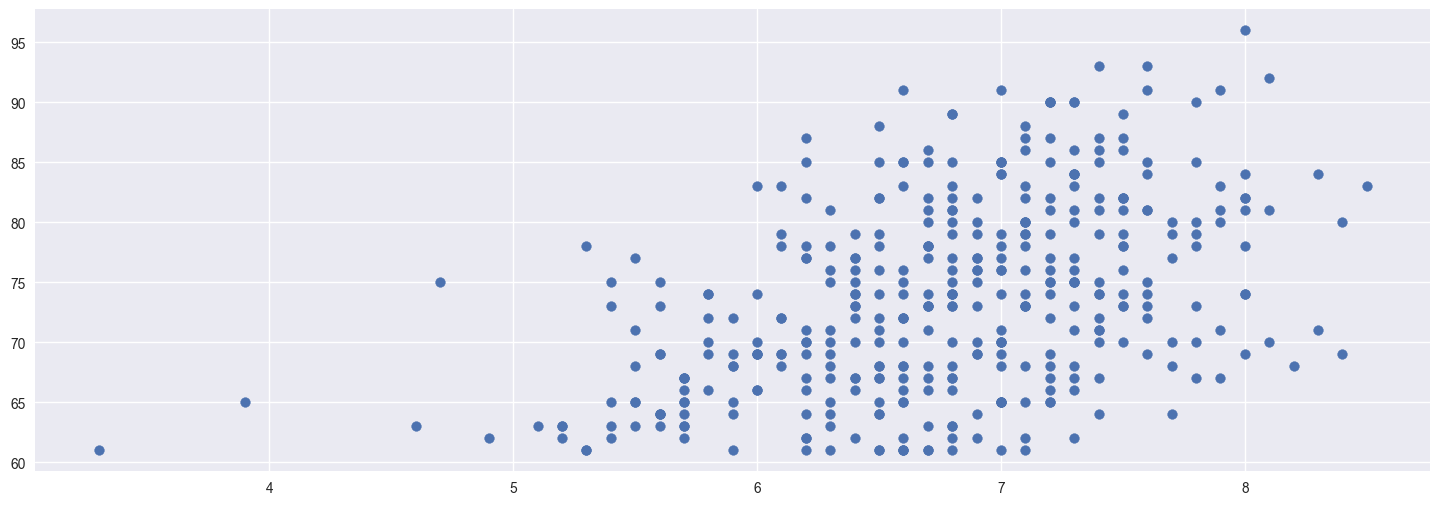

In [259]:
plt.figure(figsize = (18,6))
plt.scatter( x = movies['Imdb_Ratings'],
             y = movies['Metascore'])



<AxesSubplot:>

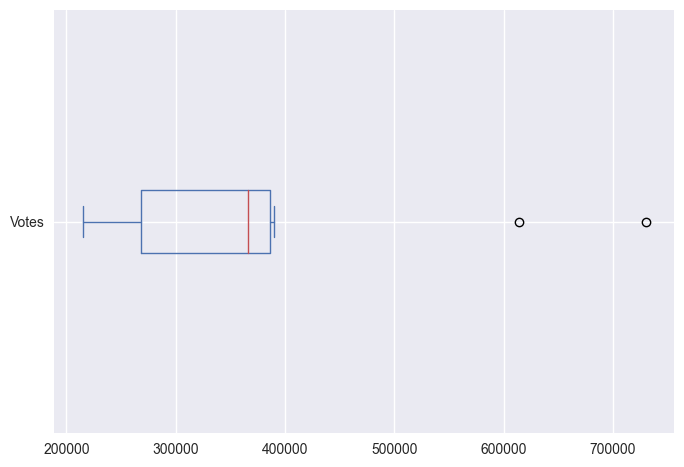

In [262]:
top10MoviesVoted['Votes'].plot.box(vert= False)

<AxesSubplot:>

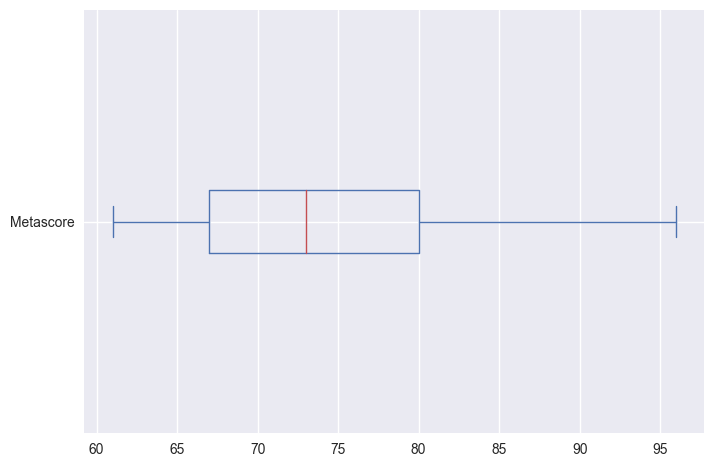

In [266]:
movies['Metascore'].plot.box(vert= False)

In [169]:
movies['Imdb_Ratings'].isna().sum()

0

<AxesSubplot:>

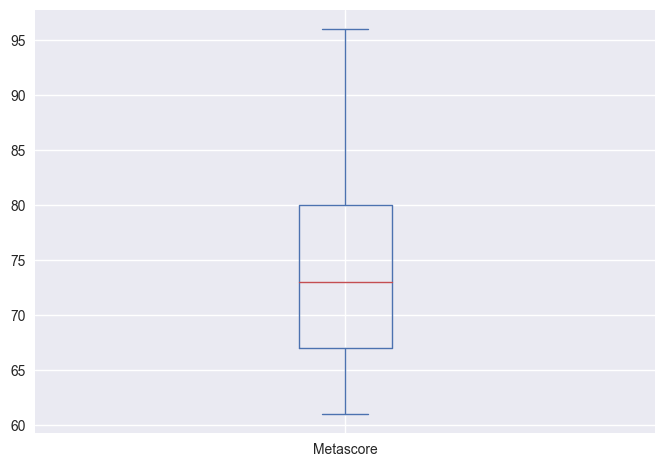

In [264]:
movies['Metascore'].plot.box()